# Capstone Project – Forecasting Bitcoin Transaction Fees

## Summary

This notebook presents the core insights and high-level workflows from our capstone project. Our goal was to develop predictive models that help users anticipate short-term Bitcoin transaction fee spikes using mempool and blockchain network data. We evaluated multiple models, compared their strengths and limitations, and highlighted key findings to support smarter transaction timing.

## Notebook Structure

I. **Project Motivation & Problem Statement**  
   Why forecasting transaction fees matters, and what questions we aim to answer.

II. **Data Overview & Exploratory Analysis**  
   Mempool structure, feature highlights, and time series patterns.

III. **Forecasting Models & Evaluation**  
   Summary of methods tried (HWES, SARIMA, XGBoost, Prophet, TFT, etc.), key metrics, and comparison plots.

IV. **Final Insights & Future Work**  
   Takeaways, model limitations, and possible extensions beyond the capstone.


## I. Project Motivation & Problem Statement

Bitcoin transaction fees are notoriously volatile and event-driven, with single-day spikes exceeding $78 million and annual costs reaching billions. Yet most tools offer only short-horizon, rule-based forecasts for the next few blocks—far from enough for users or developers needing cost-aware planning.

Our project addresses this gap by forecasting transaction fees—specifically the `fastestFee` tier—up to 24 hours in advance. We aim to identify periods of extreme volatility and provide actionable guidance on fee magnitudes within those windows.

We experimented with a wide range of models, from classical time series (SARIMA, HWES) to machine learning (XGBoost) and deep learning (Temporal Fusion Transformer). While traditional models captured general trends, they struggled with sharp jumps. TFT achieved the best performance, improving RMSE and a custom volatility-sensitive loss by 25–35%.

The result is a modular, reproducible system that combines clear analysis with extensible pipelines—offering a practical foundation for longer-horizon fee forecasting in the Bitcoin ecosystem.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path
src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))
from preprocess_raw_parquet import preprocess_raw_parquet
from XGBoost import data_split, create_lag_features_fast
from prophet import Prophet
from pytorch_forecasting import TemporalFusionTransformer, DeepAR
import joblib
from prophet.serialize import model_from_json
import lightning.pytorch as pl
from transform_fee_data_dl import transform_fee_data_dl
from split_series import split_series
from scale_series import scale_series
from plot_series import plot_series
from custom_loss_eval import eval_metrics

/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
PROJECT_ROOT = Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "mar_5_may_12.parquet"
MODEL_DIR = PROJECT_ROOT / "results" / "models"
PLOT_DIR = PROJECT_ROOT /"results"/"plots"
TABLE_DIR = PROJECT_ROOT /"results"/"tables"
OUTPUT_CSV = PROJECT_ROOT /"results"/"tables"/ "all_model_predictions.csv"

In [3]:
df_full = preprocess_raw_parquet(DATA_PATH)
df_full = df_full[:-96]
df_test = df_full.tail(96).copy()
df_test.reset_index(inplace=True)
df_test

,timestamp,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
0,2025-05-10 20:00:00,1.674466e+06,997984.750000,2088.000000,2.272682e+06,1.664282,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-05-10 20:15:00,1.601436e+06,997936.166667,3278.333333,3.632121e+06,2.680387,3.333333,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-05-10 20:30:00,1.563615e+06,997985.916667,3351.000000,4.477459e+06,3.377515,4.000000,3.333333,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-05-10 20:45:00,1.643071e+06,997973.333333,3545.333333,4.172588e+06,3.072167,4.000000,3.333333,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-05-10 21:00:00,1.673251e+06,997978.833333,2737.666667,3.769659e+06,3.106410,4.000000,3.333333,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2025-05-11 18:45:00,7.225843e+05,470774.833333,1282.333333,1.334593e+06,0.580391,1.333333,1.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,2025-05-11 19:00:00,3.872140e+05,240659.750000,819.666667,6.658160e+05,0.000000,1.000000,1.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,2025-05-11 19:15:00,1.479687e+06,917250.833333,2951.000000,2.899317e+06,2.102116,2.333333,1.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,2025-05-11 19:30:00,1.600430e+06,997964.500000,3674.333333,5.290451e+06,3.045255,4.000000,2.000000,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## II. Exploratory Data Analysis (EDA)

To guide feature engineering and model selection, we performed an in-depth exploratory analysis of historical Bitcoin transaction fees and network activity.

### 1. Overview of Fee Volatility

The `fastestFee` series exhibits extreme volatility, with frequent spikes far above the average. This motivated our emphasis on volatility-sensitive metrics.

![Fee Overview](../img/fastest_fee_peaks.png)

### 2. Distribution of Fee and Congestion Features

Many features—especially fee counts—are highly skewed. We applied log transformations to normalize them before modeling.

![Feature Distributions](../img/fastest_fee_distribution.png)

### 3. Seasonality and Trend

We decomposed the target series into trend, seasonality, and residuals. Daily cycles are clearly visible, aligning with Bitcoin block times and global trading activity.

![Seasonality](../img/decomposition_multiplicative.png)

### 4. Stationarity Check

We applied the Augmented Dickey-Fuller (ADF) test to verify whether the `fastestFee` series is stationary—an essential assumption for classical time series models like SARIMA. 

- **Null Hypothesis $H_0$**: The data is non-stationary.
- **Test Result**: We reject $H_0$ at the 1% significance level both globally (full series) and locally (weekly splits).
- **Conclusion**: The series is stationary and no differencing is required for modeling.

This validation allows us to directly apply autoregressive models without transformation for stationarity.

### 5. Autocorrelation & Lag Analysis

Autocorrelation (ACF) and partial autocorrelation (PACF) plots confirm the presence of short-term dependencies, especially within the first few lags. This supports the use of autoregressive models such as SARIMA.

![ACF & PACF](../img/acf_pacf_plot.png)


### 6. Optimal Resampling Frequency

We computed decay ratios across different sampling intervals to evaluate AR(1)-like temporal dependence. A 15-minute frequency showed the strongest short-term predictability and was used in all models.

![Decay Ratio](../img/optimal_interval.png)

### 7. Correlation Analysis

Fee-related congestion features such as totalFee showed strong correlations with fastestFee, motivating their inclusion in tree-based and deep learning models.

![Correlation Heatmap](../img/spearman_correlation.png)

> **Note:** For a more detailed walkthrough of the data exploration process, please refer to the companion notebook: [data_spec.ipynb](analysis/data_spec.ipynb).

## III. Forecasting Model Analysis

We experimented with a variety of forecasting models spanning three families: classical time series models, machine learning regressors, and deep learning architectures. Each brought different strengths and limitations to the task of long-horizon Bitcoin fee forecasting.

### 1. Load All Trained Models

We first load the final checkpoint or serialized object for each trained model to prepare for evaluation and comparison.


In [4]:
with open(MODEL_DIR /'prophet_model.json', 'r') as fin:
    prophet_model = model_from_json(fin.read())  # Load model

In [5]:
from torch.serialization import add_safe_globals
# Set the root directory of the project and add the advanced_tft scripts folder to the Python path
project_root = Path("../").resolve()
sys.path.insert(0, str(project_root / "scripts" / "advanced_tft"))

# Path to the model checkpoint file (This is the best one, use this for validation)
best_model_path = "../results/models/best-model-tft-v5.pt"
# Register TemporalFusionTransformer as a safe class for unpickling (required in PyTorch 2.6+)
add_safe_globals([TemporalFusionTransformer]) 
# Load the entire saved model (assuming it was saved using torch.save(model, path))
# Setting weights_only=False ensures the full object is deserialized
model = torch.load(best_model_path, map_location="cpu", weights_only=False)

In [6]:
deepar_model = DeepAR.load_from_checkpoint(MODEL_DIR / "best_deepar_model_v5.ckpt")
_ = deepar_model.eval()

/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [7]:
with open(MODEL_DIR / "hwes_best_train.pkl", "rb") as f:
    hwes_model = pickle.load(f)


In [8]:
with open(MODEL_DIR / "sarima_final_model.pkl", "rb") as f:
    sarima_model = pickle.load(f)

In [9]:
with open(MODEL_DIR / "xgboost.pkl", "rb") as f:
    xgb_model = joblib.load(MODEL_DIR / "xgboost.pkl")

/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/pickle.py:1718: UserWarning: [14:40:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748169209682/work/src/gbm/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


### 2. Forecast Model Evaluation

We now evaluate and compare the performance of each forecasting model on the 24-hour horizon. Each model is assessed using both standard and custom metrics, with visualizations provided for forecast vs actual fee trajectories.

#### Custom Loss — MAE with Standard Deviation and Deviation Penalties

In highly volatile time series like Bitcoin transaction fees, capturing **not just the mean**, but also the **variance** and **shape** of the signal is critical.  
A model trained or evaluated purely with MAE might predict smooth outputs that minimize average error but completely miss spikes — which are crucial for users estimating fee costs.

To address this, we use a custom loss function: `custom_loss`.

---

##### Why Use `custom_loss`?

This loss improves over traditional MAE by adding two structure-aware penalties:

1. **Standard deviation penalty**  
   Encourages the predicted variance to match the target’s variance — helping the model learn realistic volatility.
   
2. **Deviation shape penalty**  
   Encourages the model to align the **shape** of the predicted curve with the target curve — ensuring spikes and valleys are in the right place.

Together with MAE, these ensure the model learns accurate and expressive predictions.

---

##### Component Breakdown

| Component         | Description |
|------------------|-------------|
| **Base MAE**     | `y_pred - target` — captures point error |
| **Std Penalty**  | `std(y_pred) - std(target)` — penalizes incorrect volatility |
| **Deviation Penalty** | `(y_pred - mean) - (target - mean)` — penalizes mismatched curve shape |

Final loss:  
total_loss = base_loss  + std_penalty + dev_error

---

##### Example

Ground Truth: y_true = [1.0, 2.0, 3.0]

Model A: y_pred_a = [0.0, 2.0, 4.0] ← Over/under-predicts symmetrically (mirrors extremes)

Model B: y_pred_b = [2.0, 2.0, 2.0] ← Predicts flat mean (smooths out dynamics)

Now evaluate them on all loss components:

| Model | MAE  | STDdiff | DevErr | MAE + STD + Dev |
|-------|------|---------|--------|------------------|
| **A** | 0.67 | 0.00    | 1.33   | **2.0**         |
| **B** | 0.67 | 0.82    | 0.67   | **2.16**         |

Model A gets the spread (STDdiff = 0) but flips the structure (high DevErr).

Model B captures the mean, but smooths out the dynamics (high STDdiff, moderate DevErr).

Overall, Model A is preferred, as it better preserves the dynamic structure of the target series.

---

##### Benefits for Fee Forecasting

| Challenge                     | How the Loss Solves It |
|------------------------------|------------------------|
| Smooth predictions that ignore volatility | Std penalty enforces realistic variation |
| Spikes/dips underpredicted   | Deviation penalty reinforces structural fidelity |
| Mean-only training misleads  | MAE is enhanced by distributional penalties |
| Volatile fee environment     | Handles high variance with stability controls |

---

By incorporating this composite loss, our model learns **not just what the fee should be**, but also **how it behaves over time**, which is essential for users and applications that depend on accurate fee forecasting.

#### 2.1 HWES (Holt-Winters Exponential Smoothing)

The HWES model effectively captures the level and daily seasonality in the `fastestFee` series. However, it heavily smooths over short-term volatility, leading to large errors during spike periods. As a result, while RMSE is acceptable, both deviation error and custom loss are significantly worse than other models.

- Captures daily cycle but fails to react to abrupt fee jumps.
- Underperforms on volatility-sensitive metrics due to over-smoothing.
- Serves as a strong seasonal baseline for comparison.

> For details, see [baseline_hwes.ipynb](analysis/baseline_hwes.ipynb)

In [ ]:
FORECAST = len(df_test)
forecast = hwes_model.forecast(FORECAST)
forecast_hwes = pd.DataFrame(forecast, columns=["y_pred"])
forecast_hwes.reset_index(drop = True, inplace = True)
forecast_hwes["timestamp"] = df_test["timestamp"].values
forecast_hwes["series_id"] = "recommended_fee_fastestFee"
forecast_hwes["y_true"] = df_test["recommended_fee_fastestFee"]

<Figure size 1200x500 with 0 Axes>

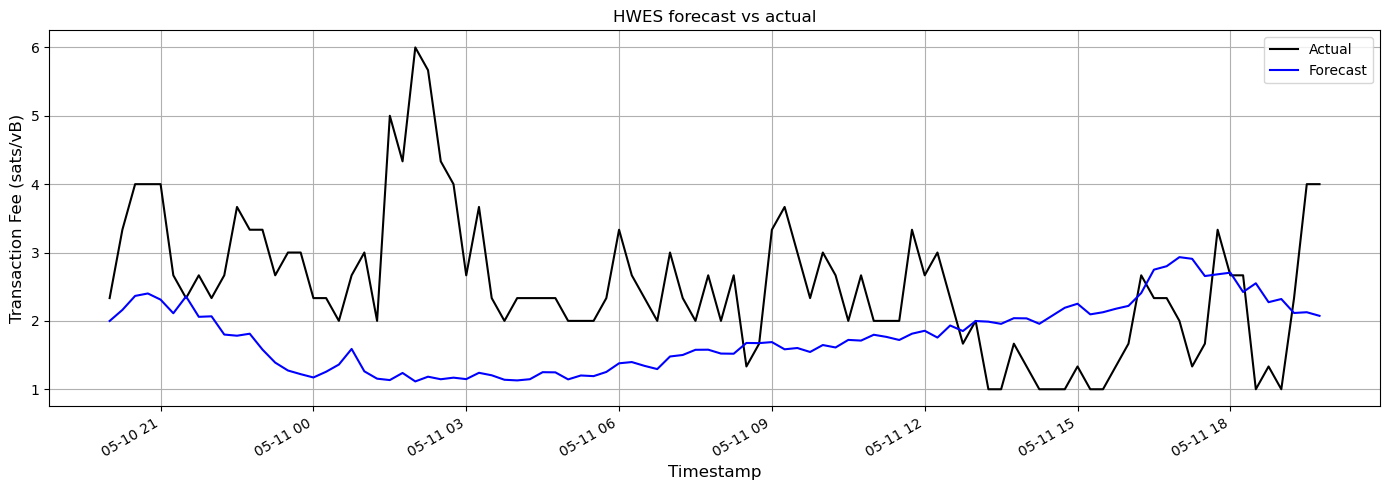

In [11]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_hwes, sid = "recommended_fee_fastestFee")
plt.title("HWES forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_hwes.png")
plt.close()

In [12]:
hwes_result = eval_metrics(forecast_hwes["y_pred"], forecast_hwes["y_true"])
hwes_result

,value
custom_loss,2.6085
std_diff,0.5155
dev_error,0.9369
mae,1.1561
mape,0.4737
rmse,1.4438


#### 2.2 SARIMA (Seasonal ARIMA)

The SARIMA model builds on autoregressive structure and incorporates daily seasonality (period = 96). While it better preserves temporal dependence than HWES and improves RMSE and MAE, it still fails to react to fee spikes. This limitation is especially clear in the deviation error and custom loss.

- Captures autoregressive structure and daily trend.
- Performs better than HWES on standard metrics (MAE, RMSE).
- Still underperforms on volatility-sensitive metrics, as it cannot anticipate sharp jumps.

> For details, see [baseline_sarima.ipynb](analysis/baseline_sarima.ipynb)

In [ ]:
fh = list(range(1, FORECAST + 1))  # 1-based step index
y_pred_sarima_log = sarima_model.predict(fh=fh)
y_pred_sarima = np.expm1(y_pred_sarima_log)  # inverse of log1p

# Format result like HWES
forecast_sarima = pd.DataFrame(y_pred_sarima.values, columns=["y_pred"])
forecast_sarima["timestamp"] = df_test["timestamp"].values
forecast_sarima["series_id"] = "recommended_fee_fastestFee"
forecast_sarima["y_true"] = df_test["recommended_fee_fastestFee"]

/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Figure size 1200x500 with 0 Axes>

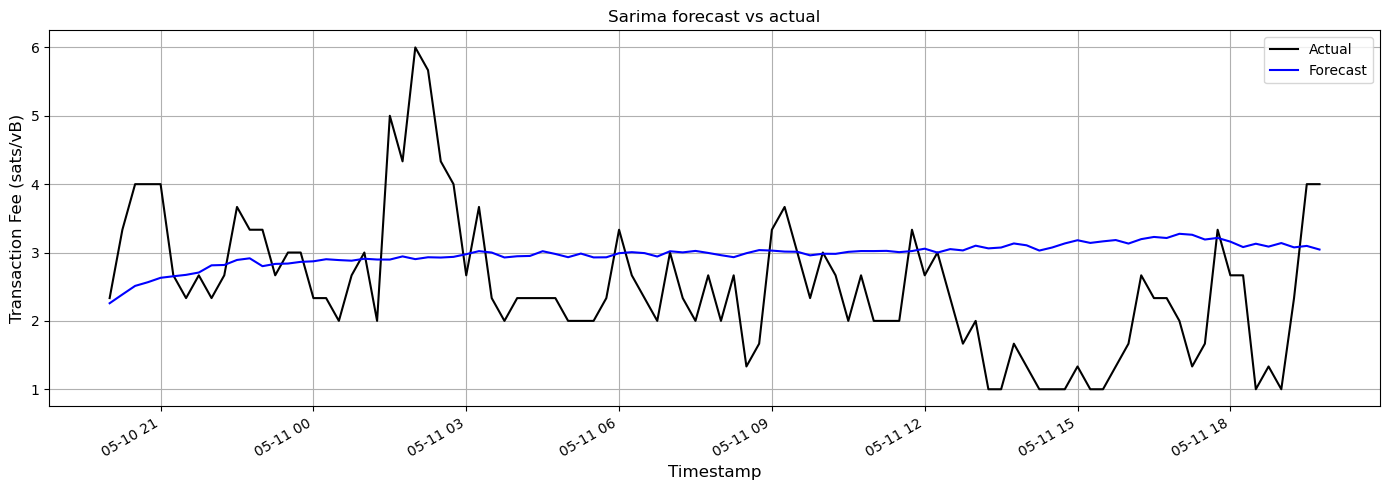

In [14]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_sarima, sid = "recommended_fee_fastestFee")
plt.title("Sarima forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_sarima.png")
plt.close()

In [15]:
sarima_result = eval_metrics(forecast_sarima["y_pred"], forecast_sarima["y_true"])
sarima_result

,value
custom_loss,2.5947
std_diff,0.8303
dev_error,0.8205
mae,0.9439
mape,0.5274
rmse,1.1689


#### 2.3 XGBoost

The XGBoost model outperformed both classical baselines in all metrics, including RMSE and the custom volatility-sensitive loss. While it struggled slightly with capturing the exact timing of sharp spikes, it did a better job than HWES and SARIMA in tracking the general shape of volatility.

- Achieved lower custom loss and RMSE than classical models.
- Benefited from congestion-related features and lagged variables.
- Still underreacted to the sharpest fee surges compared to deep learning models.

> For details, see [baseline_xgboost.ipynb](analysis/baseline_xgboost.ipynb)

In [ ]:
# Generate lag features
lags = range(1, 193)
df_xgb_full = create_lag_features_fast(df_full, 'recommended_fee_fastestFee', lags)

# Split data
X_train, X_test, y_train, y_test = data_split(df_xgb_full, 15)

# Forecast using sktime-style forecaster
y_pred_xgboost = xgb_model.predict(fh=fh, X=X_test)

# Format like other forecasts
forecast_xgb = pd.DataFrame(y_pred_xgboost.values, columns=["y_pred"])
forecast_xgb["timestamp"] = df_test["timestamp"].values  # assumes df_test has timestamps aligned
forecast_xgb["series_id"] = "recommended_fee_fastestFee"
forecast_xgb["y_true"] = df_test["recommended_fee_fastestFee"]

<Figure size 1200x500 with 0 Axes>

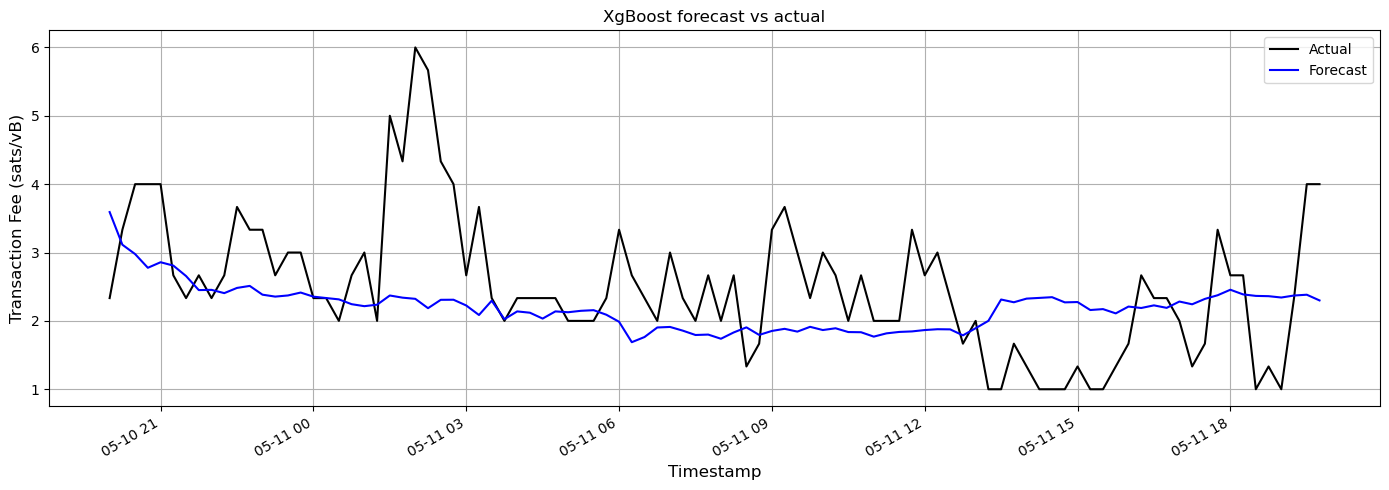

In [17]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_xgb, sid = "recommended_fee_fastestFee")
plt.title("XgBoost forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_xgboost.png")
plt.close()

In [18]:
xgb_result = eval_metrics(forecast_xgb["y_pred"], forecast_xgb["y_true"])
xgb_result

,value
custom_loss,2.2034
std_diff,0.6822
dev_error,0.7425
mae,0.7787
mape,0.3469
rmse,1.0410


#### 2.4 Prophet (Additive Time Series Decomposition)

Prophet is built for automated trend and seasonality modeling. It captures daily patterns reasonably well, but its strong trend assumptions lead to poor reactivity during sharp volatility.

- Automatically detects daily seasonality and extrapolates trend.
- Performs moderately on standard metrics, but fails under high volatility.
- Custom loss is high due to missed spikes and over-smoothed transitions.

> For details, see [advanced_prophet.ipynb](analysis/advanced_prophet.ipynb)


In [ ]:
future = prophet_model.make_future_dataframe(periods=96, freq='15min')
forecast = prophet_model.predict(future)
y_pred_prophet = forecast.iloc[-96:]
y_pred_prophet = np.expm1(y_pred_prophet["yhat"])
forecast_prophet = pd.DataFrame(y_pred_prophet.values, columns=["y_pred"])
forecast_prophet["timestamp"] = df_test["timestamp"].values  # assumes df_test has timestamps aligned
forecast_prophet["series_id"] = "recommended_fee_fastestFee"
forecast_prophet["y_true"] = df_test["recommended_fee_fastestFee"]

<Figure size 1200x500 with 0 Axes>

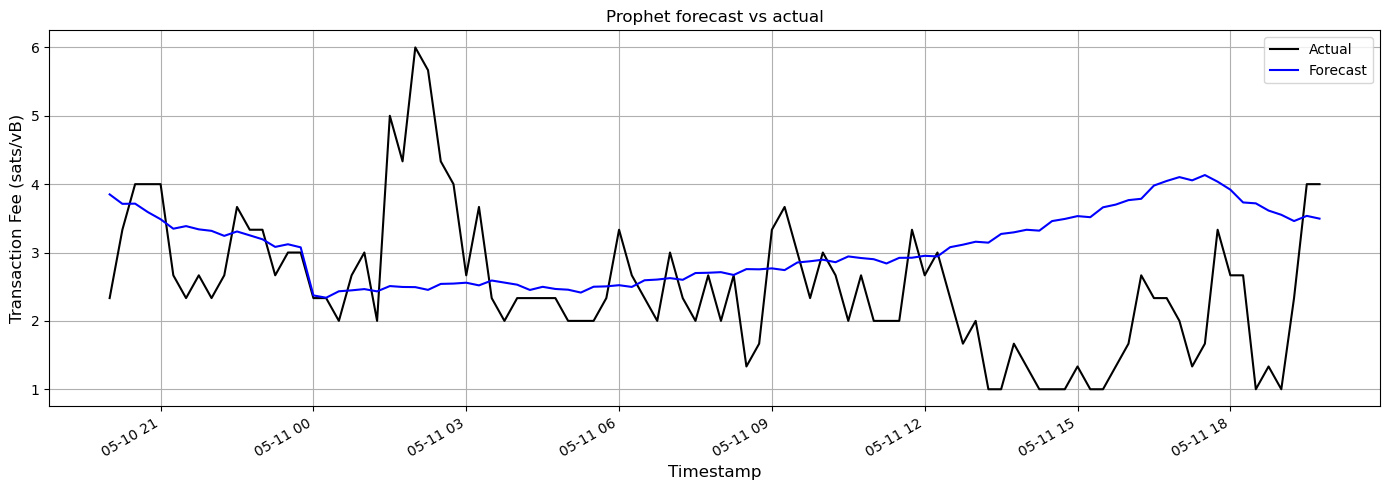

In [21]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_prophet, sid = "recommended_fee_fastestFee")
plt.title("Prophet forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_prophet.png")
plt.close()

In [29]:
prophet_result = eval_metrics(forecast_prophet["y_pred"], forecast_prophet["y_true"])
prophet_result

,value
custom_loss,2.4282
std_diff,0.4920
dev_error,0.9265
mae,1.0098
mape,0.5807
rmse,1.3430


#### 2.5 DeepAR (AutoRegressive RNN)

DeepAR models the `fastestFee` as an autoregressive recurrent neural network trained over multiple rolling windows. While it improves over Prophet in terms of RMSE and MAE, it still struggles with deviation error. The smooth forecast reflects its RNN structure, which is good at general trends but less responsive to sharp, local spikes.

- Captures autoregressive dynamics better than Prophet or HWES.  
- Performs well on MAE and RMSE, but still under-reacts to spikes.  
- Offers moderate improvement in deviation-sensitive metrics over simpler models.

> For details, see [advanced_deepar.ipynb](analysis/advanced_deepar.ipynb)

In [ ]:
df_deeplearning = transform_fee_data_dl(df_full)  # Adds time encodings, reshapes to long format, assigns time_idx
df_train_dl, df_valid_dl = split_series(df_deeplearning, 96)
df_train_dl, df_valid_dl, scaler = scale_series(df_train_dl, df_valid_dl)
df_true = df_valid_dl[
    lambda x: (x.time_idx > x.time_idx.max() - 96) & (x.time_idx <= x.time_idx.max())
]
pl.seed_everything(42)
raw_predictions = deepar_model.predict(
    df_valid_dl,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="cpu")
)
# Post-process prediction tensor → median forecast
pred_np = (
    raw_predictions.output.prediction.detach().cpu().numpy()
)  # Shape: (samples, series, time)
y_pred_da = np.median(pred_np, axis=-1).flatten()  

# Merge predictions with metadata and ground truth
df_eval_da = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        series_id=df_true["series_id"],
        y_true = df_true["target"],
        y_pred=y_pred_da,
        
    )
)
forecast_deepar = df_eval_da[df_eval_da["series_id"] == "recommended_fee_fastestFee"]


Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


<Figure size 1200x500 with 0 Axes>

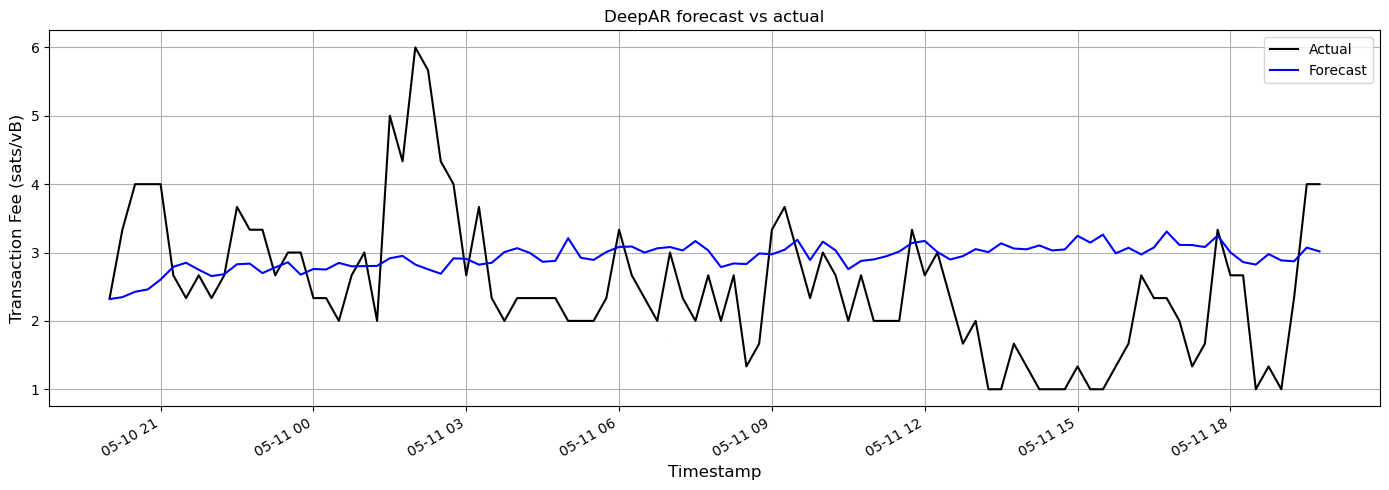

In [23]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_deepar, sid = "recommended_fee_fastestFee")
plt.title("DeepAR forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_deepAR.png")
plt.close()

In [24]:
deepar_result = eval_metrics(forecast_deepar["y_pred"], forecast_deepar["y_true"])
deepar_result

,value
custom_loss,2.5475
std_diff,0.8131
dev_error,0.8103
mae,0.9241
mape,0.5105
rmse,1.1527


#### 2.6 Temporal Fusion Transformer (TFT)

The Temporal Fusion Transformer (TFT) combines attention mechanisms with recurrent encoders to capture both short-term dependencies and long-term patterns. It is the only model that consistently anticipates spike behavior in the `fastestFee` series, achieving the best performance across all metrics—especially custom loss and RMSE.

- Effectively models complex temporal dynamics and lagged external inputs.  
- Yields the lowest RMSE and custom loss among all models.  
- Demonstrates robustness in both smooth and volatile periods.

> For details, see [advanced_tft.ipynb](analysis/advanced_tft.ipynb)

In [ ]:
# Predict using the loaded TFT model
pred = model.predict(
    df_valid_dl, # Since we have put target and other not known covariates into time_varying_unknown_reals. We can simply put df_valid here for prediction
    mode="raw",  # Return raw quantile outputs
    return_index=True,  # Return index values for later merging
    return_x=True,  # Return input data (x) as well
    trainer_kwargs=dict(accelerator="gpu"),  # Use GPU for faster inference
)
# Shape: (batch, decoder_length)
batch, pred_len = pred.x["decoder_time_idx"].shape

# Convert raw tensor to NumPy for post-processing
y_pred_tft = pred.output.prediction.detach().cpu().numpy().flatten()



# Combine predictions with true values and metadata
df_eval_tft = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        series_id=df_true["series_id"],
        y_true = df_true["target"],
        y_pred=y_pred_tft
    )
)

# Final output: ready for evaluation or visualization
forecast_tft = df_eval_tft[df_eval_tft["series_id"] == "recommended_fee_fastestFee"]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


<Figure size 1200x500 with 0 Axes>

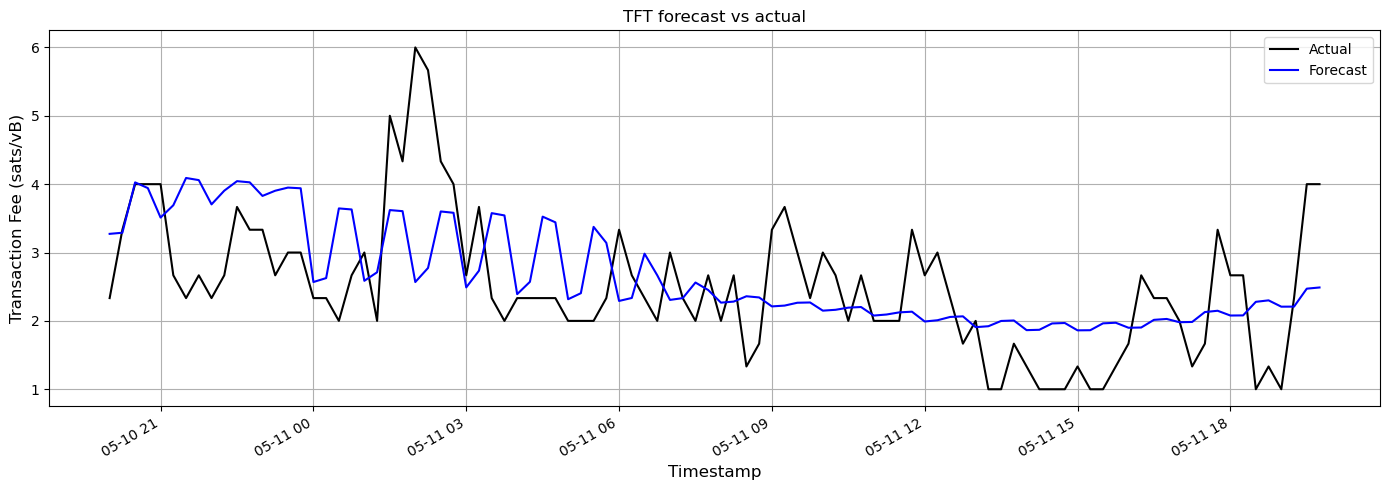

In [26]:
plt.figure(figsize=(12, 5))
ax = plot_series(forecast_tft, sid = "recommended_fee_fastestFee")
plt.title("TFT forecast vs actual")
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(PLOT_DIR / "forecast_tft.png")
plt.close()

In [27]:
tft_result = eval_metrics(forecast_tft["y_pred"], forecast_tft["y_true"])
tft_result

,value
custom_loss,1.7770
std_diff,0.2849
dev_error,0.7379
mae,0.7542
mape,0.3470
rmse,0.9423


## IV. Forecast Comparison & Discussion

To summarize model performance, we compiled all evaluation metrics into a single table:

In [28]:
tft_result.columns = ["TFT"]
deepar_result.columns = ["DeepAR"]
prophet_result.columns = ["Prophet"]
sarima_result.columns = ["SARIMA"]
hwes_result.columns = ["HWES"]
xgb_result.columns = ["XGBoost"]

# Combine all
all_results_df = pd.concat([
    tft_result,
    deepar_result,
    prophet_result,
    sarima_result,
    hwes_result,
    xgb_result
], axis=1)

# Optional: round for readability
all_results_df = all_results_df.round(4)
all_results_df.to_csv(TABLE_DIR / "all_model_metrics.csv")
# Show combined result
all_results_df

,TFT,DeepAR,Prophet,SARIMA,HWES,XGBoost
custom_loss,1.7770,2.5475,2.4282,2.5947,2.6085,2.2034
std_diff,0.2849,0.8131,0.4920,0.8303,0.5155,0.6822
dev_error,0.7379,0.8103,0.9265,0.8205,0.9369,0.7425
mae,0.7542,0.9241,1.0098,0.9439,1.1561,0.7787
mape,0.3470,0.5105,0.5807,0.5274,0.4737,0.3469
rmse,0.9423,1.1527,1.3430,1.1689,1.4438,1.0410


### Key Takeaways

- **TFT outperforms all other models**, particularly in volatility-sensitive metrics (`custom_loss`, `rmse`, and `mae`), confirming its ability to adapt to sharp fee fluctuations.
- **Tree-based XGBoost** performs better than all classical models on most metrics, showing that external features contribute predictive power.
- **Prophet** and **HWES** struggle with deviation and custom loss due to their strong smoothing effects.
- **SARIMA** benefits from autoregressive structure and daily seasonality, outperforming HWES but still underreacting to sudden jumps.
- **DeepAR** is more expressive than classical models but slightly underperforms TFT due to lack of attention mechanisms and longer convergence time.

Overall, TFT provides the most accurate and reliable long-horizon forecasts. However, it also comes with higher training complexity and compute cost. The system is designed to support future experimentation, including potential ensemble methods or fine-tuned variants of TFT.

However, some limitations remain:
- Models underperform during extreme fee spikes due to the reactive nature of features and limited historical coverage.
- Deep learning models like TFT require careful tuning and are computationally expensive.

Future directions include:
- Expanding the feature set with real-time mempool states or macro indicators.
- Exploring ensemble strategies or online learning methods for adaptive prediction.
- Building an API or dashboard to deliver real-time fee forecasts to end-users.

This foundation sets the stage for practical deployment and further innovation in Bitcoin network analytics.